# 5. CNN을 이용한 분류 (CIFAR10)

합성곱 신경망(Convolutional Neural Network)를 이용한 이미지 분류

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 5.1 CIFAR10 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/deeplearningbro/pytorch

/content/gdrive/My Drive/deeplearningbro/pytorch


In [ ]:
# CIFAR10: 클래스 10개를 가진 이미지 데이터
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


## 5.2 CNN 모델 구축

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.feature_extraction = nn.Sequential(nn.Conv2d(3, 6, 5), 
                                                nn.ReLU(),
                                                nn.MaxPool2d(2, 2), 
                                                nn.Conv2d(6, 16, 5),
                                                nn.ReLU(),
                                                nn.MaxPool2d(2, 2))
        
        self.classifier = nn.Sequential(nn.Linear(16 * 5 * 5, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 10))
                                        
    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = self.classifier(x)

        return x

net = Net().to(device) # 모델 선언

In [ ]:
print(net)
# 32 -> 28 ->14 -> 10 -> 5

Net(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
    (3): ReLU()
  )
)


## 5.3 모델 학습하기

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수

for epoch in range(10):  # 30번 학습을 진행한다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = net(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

[1] loss: 1.864
[2] loss: 1.430
[3] loss: 1.283
[4] loss: 1.165
[5] loss: 1.082
[6] loss: 1.022
[7] loss: 0.971
[8] loss: 0.927
[9] loss: 0.888
[10] loss: 0.855
Finished Training


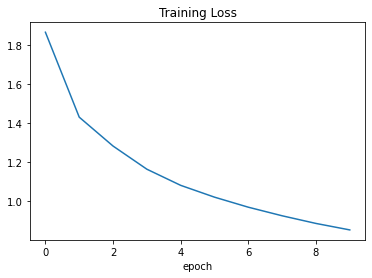

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.4 모델 저장하기

In [ ]:
PATH = './models/cifar_net.pth' # 모델 저장 경로 
torch.save(net.state_dict(), PATH) # 모델 저장

## 5.5 모델 불러오기

In [ ]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다. 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

## 5.6 모델 정확도(Accuracy) 구하기

In [ ]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) # 최댓값과 max_indices(최댓값의 위치)를 출력
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %
